In [1]:
%pip install astro-datasets numpy matplotlib albumentations adapt

     |████████████████████████████████| 9.4 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 123 kB 52.7 MB/s eta 0:00:01
     |████████████████████████████████| 99 kB 19.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 50.2 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 18.3 MB/s eta 0:00:01
     |████████████████████████████████| 295 kB 57.3 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 58.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 50.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 52.8 MB/s eta 0:00:01
     |████████████████████████████████| 33.8 MB 29.5 MB/s eta 0:00:01    |█████▊                          | 6.0 MB 29.5 MB/s eta 0:00:01
     |████████████████████████████████| 14.0 MB 18.6 MB/s eta 0:00:01
     |████████████████████████████████| 48.3 MB 20.8 MB/s eta 0:00:01
     |████████████████████████████████| 701 kB 48.6 MB/s eta 0:00:01
     |████████████████████████████

In [2]:
import numpy as np
import time, sys, os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import astro_datasets
import matplotlib.pyplot as plt
import albumentations as alb
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

2022-12-08 12:49:08.593422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(cmd_train, cmd_test, cmd_val), info = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'IllustrisTNG', 'field': 'Mtot', 
                                                 'parameters': ['omegam']})

2022-12-08 12:49:11.016499: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/IllustrisTNG_Mtot_omegam/cmd/1.0.4.incomplete29ZMMW/cmd-train.tfrecord*...…

Dataset cmd downloaded and prepared to /root/tensorflow_datasets/IllustrisTNG_Mtot_omegam/cmd/1.0.4. Subsequent calls will reuse this data.


2022-12-08 12:53:22.012423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 12:53:22.602292: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78935 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0a:00.0, compute capability: 8.0


In [4]:
(simba_train, simba_test, simba_val), info_simba = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'SIMBA', 'field': 'Mtot', 
                                                 'parameters': ['omegam']})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/SIMBA_Mtot_omegam/cmd/1.0.4.incompleteGY4HFK/cmd-train.tfrecord*...:   0%|…

Dataset cmd downloaded and prepared to /root/tensorflow_datasets/SIMBA_Mtot_omegam/cmd/1.0.4. Subsequent calls will reuse this data.


In [5]:
# define preprocessing, normalization and augmentation functions

def normalize(image, label):  
    image = tf.math.asinh(image)
    image = image - 26
    return image, label

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[256, 256])
    return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image],\
                                Tout=tf.float32)
    return aug_img, label

def set_shapes(img, label, img_shape=(256, 256, 1)):
    img.set_shape(img_shape)
    label.set_shape(1,)
    return img, label


# Separating images from labels

def get_features(features, labels):
    return features
 
def get_labels(features, labels):
    return labels

# Define augmentation pipeline

transforms = alb.Compose([alb.VerticalFlip(p=0.6),
                          alb.HorizontalFlip(p=0.6),
                          alb.RandomRotate90(p=0.6)])


In [6]:
btch_size = 128

In [7]:
cmd_train = cmd_train.repeat(count=3) # increase dataset size
cmd_train = cmd_train.map(process_data)
cmd_train = cmd_train.map(set_shapes)
cmd_train = cmd_train.map(normalize)
cmd_train = cmd_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_test = cmd_test.map(normalize)
cmd_test = cmd_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_val = cmd_val.map(normalize)
cmd_val = cmd_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
simba_test = simba_test.map(normalize)
simba_test = simba_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

simba_train = simba_train.map(normalize)
simba_train = simba_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
H = 7

In [10]:
encoder = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same', input_shape=(256, 256, 1)),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(128*H, kernel_size=4, strides=1, padding = 'valid'),  
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Flatten()
])

In [11]:
task = tf.keras.models.Sequential([
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64*H),
    tf.keras.layers.LeakyReLU(0.2), 
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(1)
])

In [12]:
opt = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
opt_enc = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
opt_disc = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)

In [13]:
epochs = 50

In [14]:
train_x_simba = simba_train.map(get_features).prefetch(tf.data.AUTOTUNE)
train_y_simba = simba_train.map(get_labels).prefetch(tf.data.AUTOTUNE)

In [15]:
mdd = MDD(encoder, task,
            loss="mae",
            metrics=["mse"],
            copy=False,
            optimizer=opt,
            optimizer_enc=opt_enc,
            optimizer_disc=opt_disc)

In [16]:
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=1,
                                                 save_best_only=True)

mdd.fit(cmd_train,\
        Xt=train_x_simba,\
        epochs=epochs,\
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),\
                     reduce_lr, cp_callback],\
        validation_data=cmd_val)

2022-12-08 12:57:33.617306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-08 12:57:34.916573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/50


2022-12-08 12:57:51.169804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 52 of 317
2022-12-08 12:58:01.153172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 103 of 317
2022-12-08 12:58:11.227955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 150 of 317
2022-12-08 12:58:21.232456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 205 of 317
2022-12-08 12:58:32.520099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 256 of 317
2022-12-08 12:58:41.133710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 305 of 317
2022-12-08 12:58:43.121438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2022

320/320 [==============================] - ETA: 0s - loss: 0.2696 - mse: 0.5611 - disc_loss: 1.3748
Epoch 1: val_loss improved from inf to 0.30531, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 205s 402ms/step - loss: 0.2696 - mse: 0.5611 - disc_loss: 1.3721 - val_loss: 0.3053 - val_mse: 0.1543 - lr: 0.0010
Epoch 2/50


2022-12-08 13:01:10.207461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 13:01:20.258407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-08 13:01:30.190241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 163 of 317
2022-12-08 13:01:40.116531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 213 of 317
2022-12-08 13:01:50.169516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 264 of 317
2022-12-08 13:02:00.303852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 315 of 317
2022-12-08 13:02:00.589320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0926 - mse: 0.0341 - disc_loss: 0.3964
Epoch 2: val_loss improved from 0.30531 to 0.13763, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 187s 395ms/step - loss: 0.0926 - mse: 0.0341 - disc_loss: 0.3960 - val_loss: 0.1376 - val_mse: 0.0267 - lr: 0.0010
Epoch 3/50


2022-12-08 13:04:17.723991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 55 of 317
2022-12-08 13:04:27.736584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 107 of 317
2022-12-08 13:04:37.690006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 160 of 317
2022-12-08 13:04:47.796307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 213 of 317
2022-12-08 13:04:57.707877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 266 of 317
2022-12-08 13:05:06.945130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0553 - mse: 0.0096 - disc_loss: 0.2259
Epoch 3: val_loss improved from 0.13763 to 0.08831, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 188s 400ms/step - loss: 0.0553 - mse: 0.0096 - disc_loss: 0.2260 - val_loss: 0.0883 - val_mse: 0.0182 - lr: 0.0010
Epoch 4/50


2022-12-08 13:07:25.707109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 13:07:35.557364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 105 of 317
2022-12-08 13:07:45.678643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 161 of 317
2022-12-08 13:07:55.661729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 217 of 317
2022-12-08 13:08:05.544032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 272 of 317
2022-12-08 13:08:13.473155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0328 - mse: 0.0022 - disc_loss: 0.1244
Epoch 4: val_loss improved from 0.08831 to 0.07863, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 186s 398ms/step - loss: 0.0328 - mse: 0.0022 - disc_loss: 0.1242 - val_loss: 0.0786 - val_mse: 0.0091 - lr: 0.0010
Epoch 5/50


2022-12-08 13:10:31.578131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 13:10:41.620179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 115 of 317
2022-12-08 13:10:51.553645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-08 13:11:01.614419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 229 of 317
2022-12-08 13:11:11.555048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 286 of 317
2022-12-08 13:11:16.908166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0270 - mse: 0.0013 - disc_loss: 0.0996
Epoch 5: val_loss improved from 0.07863 to 0.02110, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 184s 399ms/step - loss: 0.0270 - mse: 0.0013 - disc_loss: 0.0996 - val_loss: 0.0211 - val_mse: 8.1418e-04 - lr: 0.0010
Epoch 6/50


2022-12-08 13:13:35.209598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 45 of 317
2022-12-08 13:13:45.159854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 89 of 317
2022-12-08 13:13:55.264763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 133 of 317
2022-12-08 13:14:05.232314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 178 of 317
2022-12-08 13:14:15.249045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 223 of 317
2022-12-08 13:14:25.190659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 268 of 317
2022-12-08 13:14:35.308543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (t

320/320 [==============================] - ETA: 0s - loss: 0.0257 - mse: 0.0012 - disc_loss: 0.0951
Epoch 6: val_loss did not improve from 0.02110
320/320 [==============================] - 194s 384ms/step - loss: 0.0257 - mse: 0.0012 - disc_loss: 0.0950 - val_loss: 0.0346 - val_mse: 0.0022 - lr: 0.0010
Epoch 7/50


2022-12-08 13:16:49.595315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 13:16:59.633972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 110 of 317
2022-12-08 13:17:09.541927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 162 of 317
2022-12-08 13:17:19.631738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 217 of 317
2022-12-08 13:17:29.525753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 272 of 317
2022-12-08 13:17:37.901966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0243 - mse: 0.0010 - disc_loss: 0.0890
Epoch 7: val_loss did not improve from 0.02110
320/320 [==============================] - 179s 376ms/step - loss: 0.0243 - mse: 0.0010 - disc_loss: 0.0890 - val_loss: 0.0288 - val_mse: 0.0016 - lr: 0.0010
Epoch 8/50


2022-12-08 13:19:48.975472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 54 of 317
2022-12-08 13:19:58.948689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 107 of 317
2022-12-08 13:20:08.908693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 160 of 317
2022-12-08 13:20:18.952618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 213 of 317
2022-12-08 13:20:28.902394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 266 of 317
2022-12-08 13:20:38.348293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0239 - mse: 9.8027e-04 - disc_loss: 0.0925
Epoch 8: val_loss did not improve from 0.02110
320/320 [==============================] - 181s 377ms/step - loss: 0.0239 - mse: 9.8027e-04 - disc_loss: 0.0924 - val_loss: 0.0616 - val_mse: 0.0046 - lr: 0.0010
Epoch 9/50


2022-12-08 13:22:49.562127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 13:22:59.644567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 111 of 317
2022-12-08 13:23:09.480926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 166 of 317
2022-12-08 13:23:19.497403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 221 of 317
2022-12-08 13:23:29.566038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 276 of 317
2022-12-08 13:23:37.117445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0249 - mse: 0.0011 - disc_loss: 0.0951
Epoch 9: val_loss did not improve from 0.02110
320/320 [==============================] - 181s 385ms/step - loss: 0.0249 - mse: 0.0011 - disc_loss: 0.0951 - val_loss: 0.0423 - val_mse: 0.0021 - lr: 0.0010
Epoch 10/50


2022-12-08 13:25:51.004795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 55 of 317
2022-12-08 13:26:01.152062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 13:26:11.066816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 168 of 317
2022-12-08 13:26:21.078561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 225 of 317
2022-12-08 13:26:31.114970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 280 of 317
2022-12-08 13:26:38.160935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0242 - mse: 0.0010 - disc_loss: 0.0981
Epoch 10: val_loss did not improve from 0.02110
320/320 [==============================] - 180s 383ms/step - loss: 0.0242 - mse: 0.0010 - disc_loss: 0.0982 - val_loss: 0.0267 - val_mse: 0.0011 - lr: 0.0010
Epoch 11/50


2022-12-08 13:28:51.339166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 13:29:01.383691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 111 of 317
2022-12-08 13:29:11.455695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 167 of 317
2022-12-08 13:29:21.366432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 223 of 317
2022-12-08 13:29:31.453615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 279 of 317
2022-12-08 13:29:38.129718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0242 - mse: 9.8141e-04 - disc_loss: 0.0973
Epoch 11: val_loss did not improve from 0.02110
320/320 [==============================] - 179s 379ms/step - loss: 0.0242 - mse: 9.8141e-04 - disc_loss: 0.0972 - val_loss: 0.1141 - val_mse: 0.0154 - lr: 0.0010
Epoch 12/50


2022-12-08 13:31:50.245073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 13:32:00.291085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-08 13:32:10.253216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 168 of 317
2022-12-08 13:32:20.143907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 225 of 317
2022-12-08 13:32:30.184067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 282 of 317
2022-12-08 13:32:36.516572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0241 - mse: 0.0010 - disc_loss: 0.0989
Epoch 12: val_loss improved from 0.02110 to 0.01645, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 184s 398ms/step - loss: 0.0241 - mse: 0.0010 - disc_loss: 0.0988 - val_loss: 0.0164 - val_mse: 4.2784e-04 - lr: 0.0010
Epoch 13/50


2022-12-08 13:34:54.566728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 47 of 317
2022-12-08 13:35:04.598327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 92 of 317
2022-12-08 13:35:14.623395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 136 of 317
2022-12-08 13:35:24.513399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 181 of 317
2022-12-08 13:35:34.533485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 224 of 317
2022-12-08 13:35:44.529975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 269 of 317
2022-12-08 13:35:54.595729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (t

320/320 [==============================] - ETA: 0s - loss: 0.0239 - mse: 9.7568e-04 - disc_loss: 0.0986
Epoch 13: val_loss did not improve from 0.01645
320/320 [==============================] - 200s 403ms/step - loss: 0.0239 - mse: 9.7568e-04 - disc_loss: 0.0986 - val_loss: 0.0364 - val_mse: 0.0016 - lr: 0.0010
Epoch 14/50


2022-12-08 13:38:14.870798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 43 of 317
2022-12-08 13:38:24.897972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 85 of 317
2022-12-08 13:38:34.832103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 130 of 317
2022-12-08 13:38:44.900362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 173 of 317
2022-12-08 13:38:54.790816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 220 of 317
2022-12-08 13:39:04.837396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 265 of 317
2022-12-08 13:39:14.773352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (t

320/320 [==============================] - ETA: 0s - loss: 0.0233 - mse: 9.1217e-04 - disc_loss: 0.0983
Epoch 14: val_loss did not improve from 0.01645
320/320 [==============================] - 201s 401ms/step - loss: 0.0233 - mse: 9.1217e-04 - disc_loss: 0.0983 - val_loss: 0.0243 - val_mse: 8.2997e-04 - lr: 0.0010
Epoch 15/50


2022-12-08 13:41:35.494140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 45 of 317
2022-12-08 13:41:45.634989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 89 of 317
2022-12-08 13:41:55.553362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 132 of 317
2022-12-08 13:42:05.622453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 178 of 317
2022-12-08 13:42:15.614683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 222 of 317
2022-12-08 13:42:25.564162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 266 of 317
2022-12-08 13:42:35.605291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (t

320/320 [==============================] - ETA: 0s - loss: 0.0241 - mse: 9.9817e-04 - disc_loss: 0.1035
Epoch 15: val_loss did not improve from 0.01645
320/320 [==============================] - 198s 397ms/step - loss: 0.0241 - mse: 9.9817e-04 - disc_loss: 0.1034 - val_loss: 0.0854 - val_mse: 0.0091 - lr: 0.0010
Epoch 16/50


2022-12-08 13:44:53.894631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 41 of 317
2022-12-08 13:45:04.066089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 83 of 317
2022-12-08 13:45:13.908667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 127 of 317
2022-12-08 13:45:23.974644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 173 of 317
2022-12-08 13:45:33.923631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 217 of 317
2022-12-08 13:45:43.989158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 262 of 317
2022-12-08 13:45:53.913877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (t

320/320 [==============================] - ETA: 0s - loss: 0.0238 - mse: 9.4441e-04 - disc_loss: 0.1029
Epoch 16: val_loss did not improve from 0.01645
320/320 [==============================] - 201s 400ms/step - loss: 0.0238 - mse: 9.4441e-04 - disc_loss: 0.1028 - val_loss: 0.0230 - val_mse: 7.8797e-04 - lr: 0.0010
Epoch 17/50


2022-12-08 13:48:14.995344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 42 of 317
2022-12-08 13:48:24.915191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 84 of 317
2022-12-08 13:48:34.968745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 126 of 317
2022-12-08 13:48:44.924147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 168 of 317
2022-12-08 13:48:54.877991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 212 of 317
2022-12-08 13:49:04.977871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 265 of 317
2022-12-08 13:49:14.513589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0236 - mse: 9.3003e-04 - disc_loss: 0.0954
Epoch 17: val_loss did not improve from 0.01645
320/320 [==============================] - 195s 389ms/step - loss: 0.0236 - mse: 9.3003e-04 - disc_loss: 0.0954 - val_loss: 0.0662 - val_mse: 0.0047 - lr: 0.0010
Epoch 18/50


2022-12-08 13:51:29.675168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 42 of 317
2022-12-08 13:51:39.749637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 85 of 317
2022-12-08 13:51:49.596075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 127 of 317
2022-12-08 13:51:59.551850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-08 13:52:09.669414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 214 of 317
2022-12-08 13:52:19.706600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 259 of 317
2022-12-08 13:52:29.672237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (t

320/320 [==============================] - ETA: 0s - loss: 0.0236 - mse: 9.3489e-04 - disc_loss: 0.0999
Epoch 18: val_loss did not improve from 0.01645
320/320 [==============================] - 200s 397ms/step - loss: 0.0236 - mse: 9.3489e-04 - disc_loss: 0.0997 - val_loss: 0.0602 - val_mse: 0.0051 - lr: 0.0010
Epoch 19/50


2022-12-08 13:54:50.095182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 42 of 317
2022-12-08 13:55:00.124412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 85 of 317
2022-12-08 13:55:10.006098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 128 of 317
2022-12-08 13:55:20.190743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 172 of 317
2022-12-08 13:55:30.167745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 218 of 317
2022-12-08 13:55:40.171583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 262 of 317
2022-12-08 13:55:50.023800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (t

320/320 [==============================] - ETA: 0s - loss: 0.0249 - mse: 0.0011 - disc_loss: 0.1106
Epoch 19: val_loss did not improve from 0.01645
320/320 [==============================] - 201s 400ms/step - loss: 0.0249 - mse: 0.0011 - disc_loss: 0.1106 - val_loss: 0.0243 - val_mse: 8.0212e-04 - lr: 0.0010
Epoch 20/50


2022-12-08 13:58:10.767029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 44 of 317
2022-12-08 13:58:20.736739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 86 of 317
2022-12-08 13:58:30.669200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 135 of 317
2022-12-08 13:58:40.688490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 183 of 317
2022-12-08 13:58:50.764926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 230 of 317
2022-12-08 13:59:00.863369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 275 of 317
2022-12-08 13:59:10.376980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0269 - mse: 0.0024 - disc_loss: 0.1136
Epoch 20: val_loss did not improve from 0.01645
320/320 [==============================] - 199s 402ms/step - loss: 0.0269 - mse: 0.0024 - disc_loss: 0.1134 - val_loss: 0.0473 - val_mse: 0.0033 - lr: 0.0010
Epoch 21/50


2022-12-08 14:01:29.660723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 41 of 317
2022-12-08 14:01:39.813685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 83 of 317
2022-12-08 14:01:49.586645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 123 of 317
2022-12-08 14:01:59.614676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 168 of 317
2022-12-08 14:02:09.632591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 212 of 317
2022-12-08 14:02:19.677545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 256 of 317
2022-12-08 14:02:29.665719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (t

320/320 [==============================] - ETA: 0s - loss: 0.0229 - mse: 8.7987e-04 - disc_loss: 0.0933
Epoch 21: val_loss did not improve from 0.01645
320/320 [==============================] - 201s 395ms/step - loss: 0.0229 - mse: 8.7987e-04 - disc_loss: 0.0932 - val_loss: 0.1339 - val_mse: 0.0210 - lr: 0.0010
Epoch 22/50


2022-12-08 14:04:50.242462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 42 of 317
2022-12-08 14:05:00.402483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 88 of 317
2022-12-08 14:05:10.281787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 136 of 317
2022-12-08 14:05:20.327430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 184 of 317
2022-12-08 14:05:30.234607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 229 of 317
2022-12-08 14:05:40.262941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 276 of 317
2022-12-08 14:05:49.460671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0228 - mse: 8.7658e-04 - disc_loss: 0.0993
Epoch 22: val_loss did not improve from 0.01645
320/320 [==============================] - 197s 397ms/step - loss: 0.0228 - mse: 8.7658e-04 - disc_loss: 0.0994 - val_loss: 0.1197 - val_mse: 0.0163 - lr: 0.0010
Epoch 23/50


2022-12-08 14:08:06.986530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 41 of 317
2022-12-08 14:08:16.931820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 83 of 317
2022-12-08 14:08:27.107700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 124 of 317
2022-12-08 14:08:37.080132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 166 of 317
2022-12-08 14:08:47.110120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 208 of 317
2022-12-08 14:08:57.104543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 250 of 317
2022-12-08 14:09:07.027063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (t

320/320 [==============================] - ETA: 0s - loss: 0.0161 - mse: 4.1691e-04 - disc_loss: 0.0609
Epoch 23: val_loss improved from 0.01645 to 0.01287, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 213s 427ms/step - loss: 0.0161 - mse: 4.1691e-04 - disc_loss: 0.0609 - val_loss: 0.0129 - val_mse: 2.6214e-04 - lr: 3.0000e-04
Epoch 24/50


2022-12-08 14:11:39.783147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 46 of 317
2022-12-08 14:11:49.905292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 88 of 317
2022-12-08 14:11:59.867396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 132 of 317
2022-12-08 14:12:10.003099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 176 of 317
2022-12-08 14:12:19.868934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 218 of 317
2022-12-08 14:12:29.815669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 264 of 317
2022-12-08 14:12:39.964834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (t

320/320 [==============================] - ETA: 0s - loss: 0.0159 - mse: 4.1279e-04 - disc_loss: 0.0692
Epoch 24: val_loss did not improve from 0.01287
320/320 [==============================] - 199s 397ms/step - loss: 0.0159 - mse: 4.1279e-04 - disc_loss: 0.0691 - val_loss: 0.0164 - val_mse: 4.3676e-04 - lr: 3.0000e-04
Epoch 25/50


2022-12-08 14:14:58.768600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 43 of 317
2022-12-08 14:15:08.685656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 85 of 317
2022-12-08 14:15:18.589832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 127 of 317
2022-12-08 14:15:28.740177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 172 of 317
2022-12-08 14:15:38.623705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 215 of 317
2022-12-08 14:15:48.539401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 261 of 317
2022-12-08 14:15:58.715199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (t

320/320 [==============================] - ETA: 0s - loss: 0.0160 - mse: 4.2147e-04 - disc_loss: 0.0759
Epoch 25: val_loss did not improve from 0.01287
320/320 [==============================] - 202s 405ms/step - loss: 0.0160 - mse: 4.2147e-04 - disc_loss: 0.0760 - val_loss: 0.0313 - val_mse: 0.0013 - lr: 3.0000e-04
Epoch 26/50


2022-12-08 14:18:20.856804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 47 of 317
2022-12-08 14:18:30.875332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 92 of 317
2022-12-08 14:18:40.808299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 137 of 317
2022-12-08 14:18:50.819629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 185 of 317
2022-12-08 14:19:00.773201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 232 of 317
2022-12-08 14:19:10.779970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 278 of 317
2022-12-08 14:19:19.226121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0163 - mse: 4.3906e-04 - disc_loss: 0.0757
Epoch 26: val_loss did not improve from 0.01287
320/320 [==============================] - 198s 401ms/step - loss: 0.0163 - mse: 4.3906e-04 - disc_loss: 0.0756 - val_loss: 0.0205 - val_mse: 5.3548e-04 - lr: 3.0000e-04
Epoch 27/50


2022-12-08 14:21:38.638606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 52 of 317
2022-12-08 14:21:48.526320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 101 of 317
2022-12-08 14:21:58.587642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 152 of 317
2022-12-08 14:22:08.545206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 204 of 317
2022-12-08 14:22:18.571148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 255 of 317
2022-12-08 14:22:28.454749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 306 of 317
2022-12-08 14:22:30.359022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0165 - mse: 4.4834e-04 - disc_loss: 0.0846
Epoch 27: val_loss did not improve from 0.01287
320/320 [==============================] - 186s 386ms/step - loss: 0.0165 - mse: 4.4834e-04 - disc_loss: 0.0846 - val_loss: 0.0434 - val_mse: 0.0029 - lr: 3.0000e-04
Epoch 28/50


2022-12-08 14:24:44.486458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 53 of 317
2022-12-08 14:24:54.504236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 103 of 317
2022-12-08 14:25:04.338554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 156 of 317
2022-12-08 14:25:14.467187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 212 of 317
2022-12-08 14:25:24.351474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 267 of 317
2022-12-08 14:25:33.246563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0161 - mse: 4.2696e-04 - disc_loss: 0.0767
Epoch 28: val_loss improved from 0.01287 to 0.01205, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 190s 410ms/step - loss: 0.0161 - mse: 4.2696e-04 - disc_loss: 0.0767 - val_loss: 0.0121 - val_mse: 2.6086e-04 - lr: 3.0000e-04
Epoch 29/50


2022-12-08 14:27:54.884475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-08 14:28:04.947483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 99 of 317
2022-12-08 14:28:14.982575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 148 of 317
2022-12-08 14:28:25.047924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 197 of 317
2022-12-08 14:28:34.888101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 247 of 317
2022-12-08 14:28:44.914485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 298 of 317
2022-12-08 14:28:48.368625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0163 - mse: 4.3742e-04 - disc_loss: 0.0825
Epoch 29: val_loss did not improve from 0.01205
320/320 [==============================] - 189s 391ms/step - loss: 0.0163 - mse: 4.3742e-04 - disc_loss: 0.0824 - val_loss: 0.0264 - val_mse: 9.9112e-04 - lr: 3.0000e-04
Epoch 30/50


2022-12-08 14:31:04.432134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 54 of 317
2022-12-08 14:31:14.399059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 105 of 317
2022-12-08 14:31:24.448902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 157 of 317
2022-12-08 14:31:34.313669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 208 of 317
2022-12-08 14:31:44.403791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 258 of 317
2022-12-08 14:31:54.476363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 306 of 317
2022-12-08 14:31:56.517624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0161 - mse: 4.2647e-04 - disc_loss: 0.0904
Epoch 30: val_loss did not improve from 0.01205
320/320 [==============================] - 184s 379ms/step - loss: 0.0161 - mse: 4.2647e-04 - disc_loss: 0.0903 - val_loss: 0.0298 - val_mse: 0.0011 - lr: 3.0000e-04
Epoch 31/50


2022-12-08 14:34:08.261562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 55 of 317
2022-12-08 14:34:18.289779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 109 of 317
2022-12-08 14:34:28.354153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 157 of 317
2022-12-08 14:34:38.439017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 203 of 317
2022-12-08 14:34:48.456472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 248 of 317
2022-12-08 14:34:58.409858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 293 of 317
2022-12-08 14:35:03.888106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0158 - mse: 4.0661e-04 - disc_loss: 0.0771
Epoch 31: val_loss did not improve from 0.01205
320/320 [==============================] - 189s 384ms/step - loss: 0.0158 - mse: 4.0661e-04 - disc_loss: 0.0770 - val_loss: 0.0503 - val_mse: 0.0037 - lr: 3.0000e-04
Epoch 32/50


2022-12-08 14:37:17.655007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 14:37:27.636209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 110 of 317
2022-12-08 14:37:37.590083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 164 of 317
2022-12-08 14:37:47.546645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 217 of 317
2022-12-08 14:37:57.534828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 268 of 317
2022-12-08 14:38:07.066547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0159 - mse: 4.2307e-04 - disc_loss: 0.0827
Epoch 32: val_loss did not improve from 0.01205
320/320 [==============================] - 182s 382ms/step - loss: 0.0159 - mse: 4.2307e-04 - disc_loss: 0.0826 - val_loss: 0.0506 - val_mse: 0.0028 - lr: 3.0000e-04
Epoch 33/50


2022-12-08 14:40:19.954302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 52 of 317
2022-12-08 14:40:29.965707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 104 of 317
2022-12-08 14:40:40.037723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 159 of 317
2022-12-08 14:40:49.965410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 210 of 317
2022-12-08 14:41:00.028857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 261 of 317
2022-12-08 14:41:09.901237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 306 of 317
2022-12-08 14:41:11.978677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0166 - mse: 4.5510e-04 - disc_loss: 0.0930
Epoch 33: val_loss did not improve from 0.01205
320/320 [==============================] - 185s 384ms/step - loss: 0.0166 - mse: 4.5510e-04 - disc_loss: 0.0931 - val_loss: 0.0240 - val_mse: 9.2671e-04 - lr: 3.0000e-04
Epoch 34/50


2022-12-08 14:43:25.462253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 54 of 317
2022-12-08 14:43:35.497753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 107 of 317
2022-12-08 14:43:45.429309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 158 of 317
2022-12-08 14:43:55.522555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 207 of 317
2022-12-08 14:44:05.385184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 256 of 317
2022-12-08 14:44:15.436634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 307 of 317
2022-12-08 14:44:17.296216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0160 - mse: 4.2923e-04 - disc_loss: 0.1378
Epoch 34: val_loss did not improve from 0.01205
320/320 [==============================] - 184s 381ms/step - loss: 0.0160 - mse: 4.2923e-04 - disc_loss: 0.1375 - val_loss: 0.0187 - val_mse: 6.0276e-04 - lr: 3.0000e-04
Epoch 35/50


2022-12-08 14:46:29.829515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 59 of 317
2022-12-08 14:46:39.756536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 115 of 317
2022-12-08 14:46:49.808746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 170 of 317
2022-12-08 14:46:59.902199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 215 of 317
2022-12-08 14:47:09.912465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 265 of 317
2022-12-08 14:47:19.850394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 316 of 317
2022-12-08 14:47:19.933349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0162 - mse: 4.2970e-04 - disc_loss: 0.0815
Epoch 35: val_loss did not improve from 0.01205
320/320 [==============================] - 183s 382ms/step - loss: 0.0162 - mse: 4.2970e-04 - disc_loss: 0.0813 - val_loss: 0.0264 - val_mse: 0.0014 - lr: 3.0000e-04
Epoch 36/50


2022-12-08 14:49:32.706211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 55 of 317
2022-12-08 14:49:42.859800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-08 14:49:52.780160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 167 of 317
2022-12-08 14:50:02.779145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 219 of 317
2022-12-08 14:50:12.750386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 274 of 317
2022-12-08 14:50:20.185470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0164 - mse: 4.4310e-04 - disc_loss: 0.0997
Epoch 36: val_loss improved from 0.01205 to 0.01123, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 187s 403ms/step - loss: 0.0164 - mse: 4.4310e-04 - disc_loss: 0.0998 - val_loss: 0.0112 - val_mse: 2.4139e-04 - lr: 3.0000e-04
Epoch 37/50


2022-12-08 14:52:39.877669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 52 of 317
2022-12-08 14:52:49.933701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 105 of 317
2022-12-08 14:52:59.817367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 160 of 317
2022-12-08 14:53:09.876839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 214 of 317
2022-12-08 14:53:19.877535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 263 of 317
2022-12-08 14:53:29.814194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 314 of 317
2022-12-08 14:53:30.280165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0163 - mse: 4.4423e-04 - disc_loss: 0.0881
Epoch 37: val_loss did not improve from 0.01123
320/320 [==============================] - 182s 379ms/step - loss: 0.0163 - mse: 4.4423e-04 - disc_loss: 0.0879 - val_loss: 0.0326 - val_mse: 0.0015 - lr: 3.0000e-04
Epoch 38/50


2022-12-08 14:55:42.266188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 59 of 317
2022-12-08 14:55:52.107526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 14:56:02.201493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 170 of 317
2022-12-08 14:56:12.222820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 227 of 317
2022-12-08 14:56:22.230728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 280 of 317
2022-12-08 14:56:29.591550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0162 - mse: 4.2856e-04 - disc_loss: 0.0803
Epoch 38: val_loss did not improve from 0.01123
320/320 [==============================] - 179s 378ms/step - loss: 0.0162 - mse: 4.2856e-04 - disc_loss: 0.0801 - val_loss: 0.0216 - val_mse: 6.2062e-04 - lr: 3.0000e-04
Epoch 39/50


2022-12-08 14:58:41.033995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-08 14:58:51.096723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 114 of 317
2022-12-08 14:59:01.088022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 169 of 317
2022-12-08 14:59:11.066676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 221 of 317
2022-12-08 14:59:21.055946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 276 of 317
2022-12-08 14:59:28.726571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0163 - mse: 4.4539e-04 - disc_loss: 0.0924
Epoch 39: val_loss did not improve from 0.01123
320/320 [==============================] - 182s 386ms/step - loss: 0.0163 - mse: 4.4539e-04 - disc_loss: 0.0923 - val_loss: 0.0755 - val_mse: 0.0074 - lr: 3.0000e-04
Epoch 40/50


2022-12-08 15:01:43.054977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 54 of 317
2022-12-08 15:01:52.963259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 105 of 317
2022-12-08 15:02:03.011133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 158 of 317
2022-12-08 15:02:12.951460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 211 of 317
2022-12-08 15:02:22.926689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 263 of 317
2022-12-08 15:02:33.027798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 315 of 317
2022-12-08 15:02:33.298612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0161 - mse: 4.2587e-04 - disc_loss: 0.0977
Epoch 40: val_loss did not improve from 0.01123
320/320 [==============================] - 184s 384ms/step - loss: 0.0161 - mse: 4.2587e-04 - disc_loss: 0.0977 - val_loss: 0.0335 - val_mse: 0.0015 - lr: 3.0000e-04
Epoch 41/50


2022-12-08 15:04:46.868483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 55 of 317
2022-12-08 15:04:57.001017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 108 of 317
2022-12-08 15:05:06.958780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 163 of 317
2022-12-08 15:05:16.909535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 217 of 317
2022-12-08 15:05:27.040941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 273 of 317
2022-12-08 15:05:34.933885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0163 - mse: 4.3255e-04 - disc_loss: 0.0960
Epoch 41: val_loss did not improve from 0.01123
320/320 [==============================] - 180s 379ms/step - loss: 0.0163 - mse: 4.3255e-04 - disc_loss: 0.0958 - val_loss: 0.0478 - val_mse: 0.0034 - lr: 3.0000e-04
Epoch 42/50


2022-12-08 15:07:47.116724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 15:07:57.044532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 15:08:07.061693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 165 of 317
2022-12-08 15:08:17.087507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 216 of 317
2022-12-08 15:08:27.105621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 267 of 317
2022-12-08 15:08:36.354423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0163 - mse: 4.3729e-04 - disc_loss: 0.1065
Epoch 42: val_loss did not improve from 0.01123
320/320 [==============================] - 181s 377ms/step - loss: 0.0163 - mse: 4.3729e-04 - disc_loss: 0.1063 - val_loss: 0.0131 - val_mse: 2.4296e-04 - lr: 3.0000e-04
Epoch 43/50


2022-12-08 15:10:47.816568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 15:10:57.707606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 108 of 317
2022-12-08 15:11:07.769800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 159 of 317
2022-12-08 15:11:17.775859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 212 of 317
2022-12-08 15:11:27.720811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 264 of 317
2022-12-08 15:11:37.766928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 313 of 317
2022-12-08 15:11:38.428402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0165 - mse: 4.5699e-04 - disc_loss: 0.1206
Epoch 43: val_loss did not improve from 0.01123
320/320 [==============================] - 184s 383ms/step - loss: 0.0165 - mse: 4.5699e-04 - disc_loss: 0.1203 - val_loss: 0.0251 - val_mse: 8.8691e-04 - lr: 3.0000e-04
Epoch 44/50


2022-12-08 15:13:51.570900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 52 of 317
2022-12-08 15:14:01.566217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 103 of 317
2022-12-08 15:14:11.624549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 154 of 317
2022-12-08 15:14:21.600364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 201 of 317
2022-12-08 15:14:31.667406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 253 of 317
2022-12-08 15:14:41.657853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 303 of 317
2022-12-08 15:14:44.372294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0160 - mse: 4.2197e-04 - disc_loss: 0.1048
Epoch 44: val_loss did not improve from 0.01123
320/320 [==============================] - 185s 380ms/step - loss: 0.0160 - mse: 4.2197e-04 - disc_loss: 0.1054 - val_loss: 0.0210 - val_mse: 5.5879e-04 - lr: 3.0000e-04
Epoch 45/50


2022-12-08 15:16:56.455529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 55 of 317
2022-12-08 15:17:06.584684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 107 of 317
2022-12-08 15:17:16.498399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 164 of 317
2022-12-08 15:17:26.580028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 221 of 317
2022-12-08 15:17:36.475225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 276 of 317
2022-12-08 15:17:43.755478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0162 - mse: 4.3621e-04 - disc_loss: 0.1354
Epoch 45: val_loss did not improve from 0.01123
320/320 [==============================] - 179s 379ms/step - loss: 0.0162 - mse: 4.3621e-04 - disc_loss: 0.1352 - val_loss: 0.0264 - val_mse: 0.0011 - lr: 3.0000e-04
Epoch 46/50


2022-12-08 15:19:55.619130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 15:20:05.591917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-08 15:20:15.647723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 168 of 317
2022-12-08 15:20:25.591440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 223 of 317
2022-12-08 15:20:35.654506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 279 of 317
2022-12-08 15:20:42.205527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0161 - mse: 4.2862e-04 - disc_loss: 0.0824
Epoch 46: val_loss did not improve from 0.01123
320/320 [==============================] - 176s 373ms/step - loss: 0.0161 - mse: 4.2862e-04 - disc_loss: 0.0824 - val_loss: 0.0212 - val_mse: 6.0595e-04 - lr: 3.0000e-04
Epoch 47/50


2022-12-08 15:22:52.123997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 15:23:02.073795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-08 15:23:12.081040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 167 of 317
2022-12-08 15:23:22.038616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 222 of 317
2022-12-08 15:23:32.123424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 280 of 317
2022-12-08 15:23:38.600940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0137 - mse: 3.0292e-04 - disc_loss: 0.0621
Epoch 47: val_loss did not improve from 0.01123
320/320 [==============================] - 177s 374ms/step - loss: 0.0137 - mse: 3.0292e-04 - disc_loss: 0.0621 - val_loss: 0.0543 - val_mse: 0.0033 - lr: 9.0000e-05
Epoch 48/50


2022-12-08 15:25:48.866499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 15:25:58.857840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-08 15:26:08.760597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 169 of 317
2022-12-08 15:26:18.831509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 223 of 317
2022-12-08 15:26:28.765277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 277 of 317
2022-12-08 15:26:36.206510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0137 - mse: 3.0098e-04 - disc_loss: 0.0708
Epoch 48: val_loss did not improve from 0.01123
320/320 [==============================] - 179s 377ms/step - loss: 0.0137 - mse: 3.0098e-04 - disc_loss: 0.0708 - val_loss: 0.0211 - val_mse: 5.5415e-04 - lr: 9.0000e-05
Epoch 49/50


2022-12-08 15:28:47.573287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 55 of 317
2022-12-08 15:28:57.755974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 110 of 317
2022-12-08 15:29:07.648399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 163 of 317
2022-12-08 15:29:17.739902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 219 of 317
2022-12-08 15:29:27.604852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 273 of 317
2022-12-08 15:29:35.324272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0136 - mse: 2.9982e-04 - disc_loss: 0.0807
Epoch 49: val_loss did not improve from 0.01123
320/320 [==============================] - 178s 375ms/step - loss: 0.0136 - mse: 2.9982e-04 - disc_loss: 0.0808 - val_loss: 0.0323 - val_mse: 0.0015 - lr: 9.0000e-05
Epoch 50/50


2022-12-08 15:31:46.038189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 15:31:55.890204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-08 15:32:05.930027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 168 of 317
2022-12-08 15:32:16.044831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 224 of 317
2022-12-08 15:32:25.939623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 281 of 317
2022-12-08 15:32:32.515957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0136 - mse: 2.9823e-04 - disc_loss: 0.0877
Epoch 50: val_loss did not improve from 0.01123
320/320 [==============================] - 179s 382ms/step - loss: 0.0136 - mse: 2.9823e-04 - disc_loss: 0.0876 - val_loss: 0.0188 - val_mse: 5.0711e-04 - lr: 9.0000e-05


In [17]:
best_model = tf.keras.models.load_model(checkpoint_path)

In [18]:
best_model.evaluate(cmd_test)

6/6 [==============================] - 1s 29ms/step - loss: 0.0113 - mse: 2.4439e-04


[0.011282533407211304, 0.00024439467233605683]

In [19]:
best_model.evaluate(simba_test)

6/6 [==============================] - 0s 29ms/step - loss: 0.0136 - mse: 3.0275e-04


[0.013590527698397636, 0.00030274788150563836]

In [20]:
yhat_cmd = best_model.predict(cmd_test)

6/6 [==============================] - 0s 25ms/step


In [21]:
yhat_simba = best_model.predict(simba_test)

6/6 [==============================] - 0s 22ms/step


In [22]:
lbl_cmd = np.concatenate([y for x, y in cmd_test], axis=0)

In [23]:
lbl_simba = np.concatenate([y for x, y in simba_test], axis=0)

In [24]:
yhat_cmd.shape

(750, 1)

In [25]:
lbl_cmd.shape

(750, 1)

In [26]:
np.mean(np.abs((lbl_cmd - yhat_cmd) / lbl_cmd))

0.038856607

In [27]:
np.mean(np.abs((lbl_simba - yhat_simba) / lbl_simba))

0.04986024

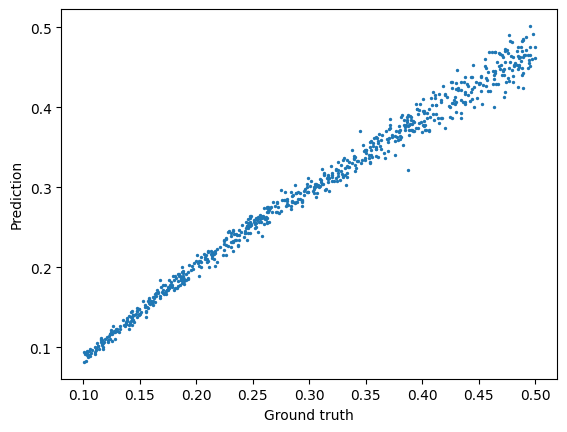

In [28]:
plt.scatter(lbl_cmd, yhat_cmd, s=2)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

plt.show()